### Image DeepDream with Tensorflow.

This code is refactored code from the [Tensorflow documentation](https://www.tensorflow.org/tutorials/generative/deepdream).

In [2]:
import IPython.display as display
import numpy as np
import PIL.Image
import skimage.io
import tensorflow as tf

In [3]:
IMAGES_DIR: str = '/images'  # Mounted to a docker volume.sss
PATH_TO_IMAGE: str = f'{IMAGES_DIR}/mazzy.png'  # My cute cat looking into a solar system projector. 😺👽

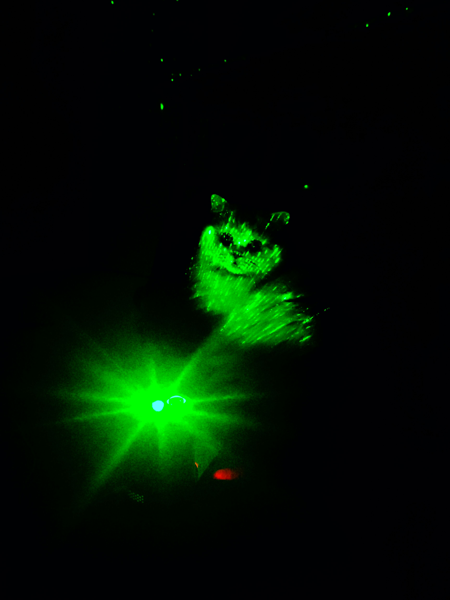

In [4]:
def convert_image_into_np_array(path_to_img, max_dim=None):
    """
    :param path_to_img:
    :param max_dim:
    :return:
    """

    _image = PIL.Image.open(path_to_img)

    if max_dim:
        _image.thumbnail((max_dim, max_dim))

    return np.array(_image)


# Normalize an image
def normalize_image(input_image):
    """
    :param input_image:
    :return:
    """

    output_image = 255 * (input_image + 1.0) / 2.0
    return tf.cast(output_image, tf.uint8)


# Display an image
def display_image(_image):
    display.display(PIL.Image.fromarray(np.array(_image)))


# Downsizing the image makes it easier to work with.
original_img = convert_image_into_np_array(PATH_TO_IMAGE, max_dim=600)
display_image(original_img)

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [6]:
def calc_loss(_image, model):
    """
    :param _image:
    :param model:
    :return:

    Pass forward the image through the model to retrieve the activations.
    Converts the image into a batch of size 1.
    """

    img_batch = tf.expand_dims(_image, axis=0)
    layer_activations = model(img_batch)

    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []

    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)


def random_roll(_image, max_roll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-max_roll, maxval=max_roll, dtype=tf.int32)
    img_rolled = tf.roll(_image, shift=shift, axis=[0, 1])
    return shift, img_rolled

In [7]:

class TiledGradients(tf.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model


    @tf.function(
        input_signature=(
                tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
                tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    def __call__(self, _img, tile_size=512):
        shift, img_rolled = random_roll(_img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]

        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])

        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]

        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                # Calculate the gradients for this tile.

                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                    loss = calc_loss(img_tile, self.model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0, 1])

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        return gradients


In [8]:
def run_deep_dream_with_octaves(
        _img,
        steps_per_octave: int = 10,
        step_size: float = 0.01,
        octaves: range = range(-2, 3),
        octave_scale: float = 1.3,
):
    _base_shape = tf.shape(_img)
    _img = tf.keras.preprocessing.image.img_to_array(_img)
    _img = tf.keras.applications.inception_v3.preprocess_input(_img)

    initial_shape = _img.shape[:-1]
    _img = tf.image.resize(_img, initial_shape)

    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(_base_shape[:-1]), tf.float32) * (octave_scale ** octave)
        _img = tf.image.resize(_img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(_img)
            _img = _img + gradients * step_size
            _img = tf.clip_by_value(_img, -1, 1)

    result = normalize_image(_img)
    return result

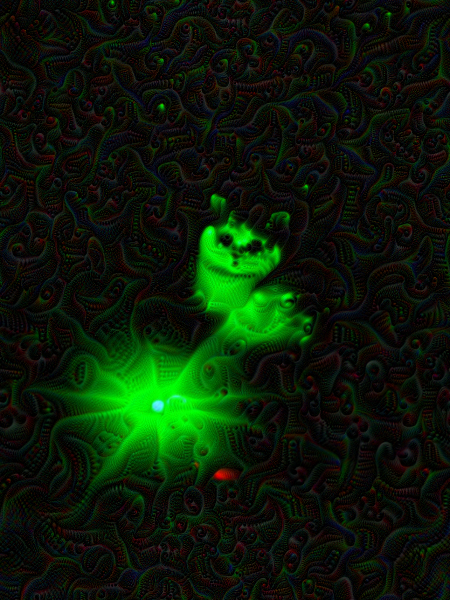

In [12]:
# Maximize the activations of these layers.
names = [
    'mixed1',
    'mixed2',
]

layers = [base_model.get_layer(name).output for name in names]

base_shape = tf.shape(original_img)[:-1]  # Original size of image shape, used to resize final deepdream.

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
get_tiled_gradients = TiledGradients(dream_model)

# Change settings below to achieve different results.
img = run_deep_dream_with_octaves(
    _img=original_img,
    steps_per_octave=20,
    step_size=0.01,
    octaves=range(-2, 5),
    octave_scale=1.3,
)

display.clear_output(wait=True)

img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)

display_image(img)

In [ ]:
# Save image.
skimage.io.imsave('/images/mazzy_deep_dreamed.png', img)